# Análisis del Autoencoder

Cargando imágenes desde: ./storage/raw/test
5000 imágenes cargadas inicialmente.
Cargando modelo ResNet50 preentrenado...
Usando dispositivo para ResNet: cpu
Extrayendo características de 5000 imágenes...
  Procesadas 50/5000 imágenes...
  Procesadas 100/5000 imágenes...
  Procesadas 150/5000 imágenes...
  Procesadas 200/5000 imágenes...
  Procesadas 250/5000 imágenes...
  Procesadas 300/5000 imágenes...
  Procesadas 350/5000 imágenes...
  Procesadas 400/5000 imágenes...
  Procesadas 450/5000 imágenes...
  Procesadas 500/5000 imágenes...
  Procesadas 550/5000 imágenes...
  Procesadas 600/5000 imágenes...
  Procesadas 650/5000 imágenes...
  Procesadas 700/5000 imágenes...
  Procesadas 750/5000 imágenes...
  Procesadas 800/5000 imágenes...
  Procesadas 850/5000 imágenes...
  Procesadas 900/5000 imágenes...
  Procesadas 950/5000 imágenes...
  Procesadas 1000/5000 imágenes...
  Procesadas 1050/5000 imágenes...
  Procesadas 1100/5000 imágenes...
  Procesadas 1150/5000 imágenes...
  Procesad

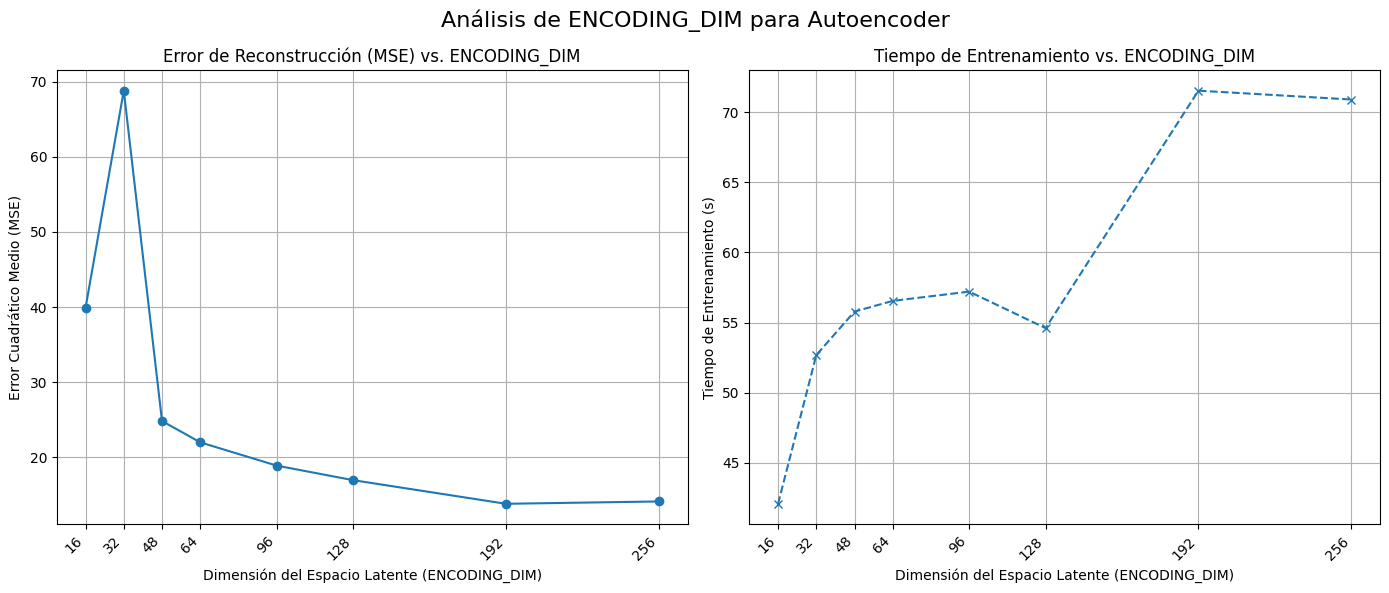

In [6]:
import os
import matplotlib.pyplot as plt
import torch
import time

from torch.utils.data import DataLoader, TensorDataset


image_dir = "./storage/raw/test"
pil_images = []
original_filenames = []

print(f"Cargando imágenes desde: {image_dir}")
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff")
all_files = sorted(os.listdir(image_dir))
for filename in all_files:
    if filename.lower().endswith(valid_extensions):
        try:
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path)
            pil_images.append(img)
            original_filenames.append(filename)
        except Exception as e:
            print(f"Advertencia: No se pudo cargar la imagen {filename}. Error: {e}")
print(f"{len(pil_images)} imágenes cargadas inicialmente.")

if not pil_images:
    print("No se cargaron imágenes válidas. Terminando ejecución.")
    exit()


feature_extractor, device_resnet = load_feature_extractor(use_gpu=False)
preprocess_transform = get_preprocess_transform()

extracted_features, valid_indices = extract_features(pil_images, feature_extractor, device_resnet, preprocess_transform)

input_dim = extracted_features.shape[1]

potential_encoding_dims = [16, 32, 48, 64, 96, 128, 192, 256]

max_intermediate_dim = input_dim // 4
encoding_dim_values_to_test = [
    dim for dim in potential_encoding_dims if dim > 0 and dim < max_intermediate_dim and dim < input_dim
]

if not encoding_dim_values_to_test:
    if max_intermediate_dim > 16:
        encoding_dim_values_to_test = [d for d in [8, 16, min(32, max_intermediate_dim -1)] if d > 0 and d < max_intermediate_dim]
    elif max_intermediate_dim > 1:
            encoding_dim_values_to_test = [max_intermediate_dim // 2, min(max_intermediate_dim -1, 1)]
            encoding_dim_values_to_test = [d for d in encoding_dim_values_to_test if d > 0] # remove non-positives
            encoding_dim_values_to_test = sorted(list(set(encoding_dim_values_to_test))) # unique and sorted
    else:
        print(f"Advertencia: Con input_dim={input_dim}, la capa intermedia es {max_intermediate_dim}.")
        print("No se pueden probar dimensiones de codificación significativamente más pequeñas con la estructura actual del AE.")
        print("Considere ajustar 'potential_encoding_dims' o la arquitectura del AE si es necesario.")

AE_EPOCHS = 20
AE_BATCH_SIZE = 32
AE_LEARNING_RATE = 1e-3

print(f"Probando las siguientes dimensiones de codificación: {encoding_dim_values_to_test}")
if encoding_dim_values_to_test:
    print(f"Usando {AE_EPOCHS} épocas para cada entrenamiento de Autoencoder en esta exploración.")
else:
    print("No hay dimensiones de codificación válidas para probar según la configuración actual.")


reconstruction_errors_ae = []
training_times_ae = []
final_losses_ae = []

features_tensor = torch.from_numpy(extracted_features).float()
dataset_explore = TensorDataset(features_tensor)

device_ae = torch.device("cuda" if USE_GPU else "cpu")
print(f"Usando dispositivo para Autoencoder: {device_ae}")


for current_encoding_dim in encoding_dim_values_to_test:
    print(f"\n--- Entrenando Autoencoder con ENCODING_DIM = {current_encoding_dim} ---")

    data_loader_explore = DataLoader(dataset_explore, batch_size=AE_BATCH_SIZE, shuffle=True)

    autoencoder_test = Autoencoder(input_dim=input_dim, encoding_dim=current_encoding_dim)

    start_train_time = time.time()

    trained_ae = train_autoencoder(
        autoencoder_test,
        data_loader_explore,
        AE_EPOCHS,
        AE_LEARNING_RATE,
        device_ae
    )
    end_train_time = time.time()
    current_training_time = end_train_time - start_train_time
    training_times_ae.append(current_training_time)

    trained_ae.eval()
    criterion_eval = nn.MSELoss(reduction='sum')
    total_mse_sum = 0

    eval_data_loader = DataLoader(dataset_explore, batch_size=AE_BATCH_SIZE, shuffle=False)

    with torch.no_grad():
        for data_batch in eval_data_loader:
            inputs = data_batch[0].to(device_ae)
            reconstructed_outputs = trained_ae(inputs)
            mse_sum_batch = criterion_eval(reconstructed_outputs, inputs)
            total_mse_sum += mse_sum_batch.item()

    avg_mse_reconstruction = total_mse_sum / len(dataset_explore)
    reconstruction_errors_ae.append(avg_mse_reconstruction)

    print(f"  ENCODING_DIM: {current_encoding_dim}, MSE de Reconstrucción Final: {avg_mse_reconstruction:.6f}, Tiempo de Entrenamiento: {current_training_time:.2f}s")

# Plot the results
if encoding_dim_values_to_test and reconstruction_errors_ae:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(encoding_dim_values_to_test, reconstruction_errors_ae, marker='o', linestyle='-')
    plt.title('Error de Reconstrucción (MSE) vs. ENCODING_DIM')
    plt.xlabel('Dimensión del Espacio Latente (ENCODING_DIM)')
    plt.ylabel('Error Cuadrático Medio (MSE)')
    plt.xticks(encoding_dim_values_to_test, rotation=45, ha="right")
    plt.grid(True)
    plt.tight_layout()


    if training_times_ae:
        plt.subplot(1, 2, 2)
        plt.plot(encoding_dim_values_to_test, training_times_ae, marker='x', linestyle='--')
        plt.title('Tiempo de Entrenamiento vs. ENCODING_DIM')
        plt.xlabel('Dimensión del Espacio Latente (ENCODING_DIM)')
        plt.ylabel('Tiempo de Entrenamiento (s)')
        plt.xticks(encoding_dim_values_to_test, rotation=45, ha="right")
        plt.grid(True)
        plt.tight_layout()


    plt.suptitle("Análisis de ENCODING_DIM para Autoencoder", fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()

    # --- Recomendaciones para ENCODING_DIM ---
    # Busque un 'codo' en el gráfico de MSE: el punto donde el error deja de disminuir significativamente al aumentar ENCODING_DIM.
    # Un ENCODING_DIM más bajo significa mayor compresión pero potencialmente mayor pérdida de información (mayor MSE).
    # Considere el equilibrio entre un MSE bajo, el grado de reducción de dimensionalidad deseado y el tiempo de entrenamiento.
    # El valor óptimo también puede depender de cómo afecte a las métricas de clustering posteriores (Silhouette, CH-index).
elif not encoding_dim_values_to_test:
    print("No se ejecutó la exploración de ENCODING_DIM porque no se encontraron dimensiones válidas para probar.")
else:
    print("No se generaron resultados para graficar.")

# Metodología

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from PIL import ImageFilter, Image

import numpy as np
import os
import warnings
import time

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.models._utils")

In [ ]:
NUM_CLUSTERS = 5
USE_GPU = False
REDUCE_DIMENSIONS = True
ENCODING_DIM = 128

AE_EPOCHS = 40
AE_BATCH_SIZE = 32
AE_LEARNING_RATE = 1e-3

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 2, input_dim // 4),
            nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 4, input_dim // 8),
            nn.BatchNorm1d(input_dim // 8),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 8, input_dim // 16),
            nn.BatchNorm1d(input_dim // 16),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 16, encoding_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim // 16),
            nn.BatchNorm1d(input_dim // 16),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 16, input_dim // 8),
            nn.BatchNorm1d(input_dim // 8),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 8, input_dim // 4),
            nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 4, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 2, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

In [ ]:
def load_feature_extractor(use_gpu):
    print("Cargando modelo ResNet50 preentrenado...")
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    modules = list(model.children())[:-1]
    feature_extractor = nn.Sequential(*modules)
    feature_extractor.eval()

    device = torch.device("cuda" if use_gpu else "cpu")
    feature_extractor.to(device)
    print(f"Usando dispositivo para ResNet: {device}")
    return feature_extractor, device

In [ ]:
def get_preprocess_transform():
    return transforms.Compose([
        transforms.Lambda(lambda img: img.filter(ImageFilter.EDGE_ENHANCE_MORE)),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
def extract_features(pil_image_list, model, device, preprocess):
    features = []
    valid_indices = []
    model.eval()
    print(f"Extrayendo características de {len(pil_image_list)} imágenes...")
    with torch.no_grad():
        for i, img_pil in enumerate(pil_image_list):
            processed = False
            if img_pil.mode != "RGB":
                try:
                    img_pil = img_pil.convert("RGB")
                except Exception as e:
                    print(f"Advertencia: No se pudo convertir la imagen en el índice {i} a RGB. Se omitirá. Error: {e}")
                    continue

            try:
                img_tensor = preprocess(img_pil)
                img_batch = img_tensor.unsqueeze(0).to(device)
                processed = True
            except Exception as e:
                print(f"Advertencia: No se pudo preprocesar la imagen en el índice {i}. Se omitirá. Error: {e}")
                continue

            if processed:
                try:
                    output = model(img_batch)
                    feature_vector = torch.flatten(output, 1)
                    features.append(feature_vector.cpu().numpy().squeeze())
                    valid_indices.append(i)
                except Exception as e:
                    print(f"Advertencia: No se pudieron extraer características para la imagen en el índice {i}. Se omitirá. Error: {e}")
                    continue

            if (i + 1) % 50 == 0:
                print(f"  Procesadas {i + 1}/{len(pil_image_list)} imágenes...")

    print("Extracción de características completada.")
    if not features:
        print("Error: No se extrajeron características. Verifica la carga y preprocesamiento de imágenes.")
        return None, None
    return np.array(features), valid_indices

In [ ]:
def train_autoencoder(model, data_loader, epochs, learning_rate, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    model.train()

    print(f"Entrenando Autoencoder por {epochs} épocas...")
    start_time = time.time()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data in data_loader:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

        avg_epoch_loss = epoch_loss / len(data_loader.dataset)
        if (epoch + 1) % 5 == 0 or epoch == 0:
             print(f"  Época [{epoch+1}/{epochs}], Pérdida (Loss): {avg_epoch_loss:.6f}")

    end_time = time.time()
    print(f"Entrenamiento del Autoencoder completado en {end_time - start_time:.2f} segundos.")
    return model

In [ ]:
def perform_kmeans_clustering(features_to_cluster, n_clusters):
    if features_to_cluster is None or features_to_cluster.shape[0] < n_clusters:
        print("Error: No hay suficientes vectores de características válidos para realizar clustering.")
        return None

    print(f"Realizando clustering K-Means con k={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    # kmeans = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    try:
        cluster_labels = kmeans.fit_predict(features_to_cluster)
        print("Clustering completado.")
        return cluster_labels
    except Exception as e:
        print(f"Error durante el clustering K-Means: {e}")
        return None

# Dataset Blood Cell

In [ ]:
image_dir = "./storage/clean/blood_cell/segmenter"
pil_images = []
original_filenames = []

print(f"Cargando imágenes desde: {image_dir}")
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff")
all_files = sorted(os.listdir(image_dir))
for filename in all_files:
    if filename.lower().endswith(valid_extensions):
        try:
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path)
            pil_images.append(img)
            original_filenames.append(filename)
        except Exception as e:
            print(f"Advertencia: No se pudo cargar la imagen {filename}. Error: {e}")
print(f"{len(pil_images)} imágenes cargadas inicialmente.")

if not pil_images:
    print("No se cargaron imágenes válidas. Terminando ejecución.")
    exit()

# 1. Cargar modelo ResNet y herramientas de preprocesamiento
feature_extractor, device_resnet = load_feature_extractor(use_gpu=USE_GPU)
preprocess_transform = get_preprocess_transform()

# 2. Extraer características de ResNet
extracted_features, valid_indices = extract_features(pil_images, feature_extractor, device_resnet, preprocess_transform)

if extracted_features is None:
    print("La extracción de características falló. No se puede continuar.")
    exit()

valid_filenames = [original_filenames[i] for i in valid_indices]
print(f"Forma de las características extraídas: {extracted_features.shape}")
print(f"Número de imágenes con características válidas: {len(valid_filenames)}")

device_ae = torch.device("cuda" if USE_GPU else "cpu")
print(f"Usando dispositivo para Autoencoder: {device_ae}")

features_to_cluster = extracted_features

# 3. Reducción de Dimensionalidad (si está habilitada)
if REDUCE_DIMENSIONS and extracted_features.shape[0] > ENCODING_DIM:
    print(f"\nReducción de Dimensionalidad con Autoencoder")
    input_dim = extracted_features.shape[1]
    if ENCODING_DIM >= input_dim:
            print(f"Advertencia: ENCODING_DIM ({ENCODING_DIM}) >= input_dim ({input_dim}). Omitiendo reducción.")
    else:
        # a) Preparar datos para PyTorch
        features_tensor = torch.from_numpy(extracted_features).float()
        dataset = TensorDataset(features_tensor)
        data_loader = DataLoader(dataset, batch_size=AE_BATCH_SIZE, shuffle=True)

        # b) Instanciar y entrenar el Autoencoder
        autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=ENCODING_DIM)
        autoencoder = train_autoencoder(autoencoder, data_loader, AE_EPOCHS, AE_LEARNING_RATE, device_ae)

        # c) Obtener las características codificadas (menor dimensión)
        autoencoder.eval()
        with torch.no_grad():
            features_tensor_gpu = features_tensor.to(device_ae)
            encoded_features_tensor = autoencoder.encode(features_tensor_gpu)
            features_reduced = encoded_features_tensor.cpu().numpy()

        print(f"Características reducidas a la forma: {features_reduced.shape}")
        features_to_cluster = features_reduced
else:
    if not REDUCE_DIMENSIONS:
            print("\nOmitiendo Reducción de Dimensionalidad")
    else:
            print(f"\nOmitiendo Reducción de Dimensionalidad (datos insuficientes o ENCODING_DIM muy grande)")


# 4. Realizar clustering K-Means
cluster_labels = perform_kmeans_clustering(
    features_to_cluster,
    NUM_CLUSTERS
)

# 5. Mostrar resultados y evaluar
if cluster_labels is not None:
    print("\nResultados del Clustering")
    results = {}
    for i, label in enumerate(cluster_labels):
        if label not in results:
            results[label] = []
        # Use valid_filenames which corresponds to the clustered features
        img_identifier = valid_filenames[i]
        results[label].append(img_identifier)

    print("\nResumen de Clusters")
    for cluster_id in sorted(results.keys()):
        print(f"Cluster {cluster_id}: Contiene {len(results[cluster_id])} imágenes")


    # Evaluate clustering
    num_unique_labels = len(set(cluster_labels))
    num_samples = len(cluster_labels)

    if num_unique_labels > 1 and num_samples > num_unique_labels:
        try:
            silhouette_avg = silhouette_score(features_to_cluster, cluster_labels)
            print(f"\nPuntaje Silhouette: {silhouette_avg:.4f}")
            print("(Varía entre -1 y 1. Más cercano a 1 es mejor.)")
        except Exception as e:
            print(f"\nNo se pudo calcular el Puntaje Silhouette: {e}")

        try:
            ch_score = calinski_harabasz_score(features_to_cluster, cluster_labels)
            print(f"Índice Calinski-Harabasz (CH): {ch_score:.2f}")
            print("(Valores más altos indican clusters mejor definidos - más densos y mejor separados.)")
        except Exception as e:
            print(f"\nNo se pudo calcular el Índice Calinski-Harabasz: {e}")
    else:
        print("\nNo se puede calcular métricas de evaluación (requiere >1 cluster y >N clusters muestras).")

else:
    print("No se pudo completar el clustering.")


for img in pil_images:
    if hasattr(img, 'close'):
        img.close()
print("\nProcesamiento finalizado.")

# Dataset CIFAR

In [ ]:
from torchvision.datasets import CIFAR10

# Cargar CIFAR-10
print("Cargando CIFAR-10 desde torchvision...")
dataset = CIFAR10(root="./data", train=False, download=True)

# Extraer imágenes PIL y etiquetas
pil_images = [img for img, _ in dataset]
original_filenames = [f"CIFAR10_img_{i}" for i in range(len(pil_images))]

# 1. Cargar modelo ResNet y herramientas de preprocesamiento
feature_extractor, device_resnet = load_feature_extractor(use_gpu=USE_GPU)
preprocess_transform = get_preprocess_transform()

# 2. Extraer características de ResNet
extracted_features, valid_indices = extract_features(pil_images, feature_extractor, device_resnet, preprocess_transform)

if extracted_features is None:
    print("La extracción de características falló. No se puede continuar.")
    exit()

valid_filenames = [original_filenames[i] for i in valid_indices]
print(f"Forma de las características extraídas: {extracted_features.shape}")
print(f"Número de imágenes con características válidas: {len(valid_filenames)}")

device_ae = torch.device("cuda" if USE_GPU else "cpu")
print(f"Usando dispositivo para Autoencoder: {device_ae}")

features_to_cluster = extracted_features

# 3. Reducción de Dimensionalidad (si está habilitada)
if REDUCE_DIMENSIONS and extracted_features.shape[0] > ENCODING_DIM:
    print(f"\nReducción de Dimensionalidad con Autoencoder")
    input_dim = extracted_features.shape[1]
    if ENCODING_DIM >= input_dim:
            print(f"Advertencia: ENCODING_DIM ({ENCODING_DIM}) >= input_dim ({input_dim}). Omitiendo reducción.")
    else:
        # a) Preparar datos para PyTorch
        features_tensor = torch.from_numpy(extracted_features).float()
        dataset = TensorDataset(features_tensor)
        data_loader = DataLoader(dataset, batch_size=AE_BATCH_SIZE, shuffle=True)

        # b) Instanciar y entrenar el Autoencoder
        autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=ENCODING_DIM)
        autoencoder = train_autoencoder(autoencoder, data_loader, AE_EPOCHS, AE_LEARNING_RATE, device_ae)

        # c) Obtener las características codificadas (menor dimensión)
        autoencoder.eval()
        with torch.no_grad():
            features_tensor_gpu = features_tensor.to(device_ae)
            encoded_features_tensor = autoencoder.encode(features_tensor_gpu)
            features_reduced = encoded_features_tensor.cpu().numpy()

        print(f"Características reducidas a la forma: {features_reduced.shape}")
        features_to_cluster = features_reduced
else:
    if not REDUCE_DIMENSIONS:
            print("\nOmitiendo Reducción de Dimensionalidad")
    else:
            print(f"\nOmitiendo Reducción de Dimensionalidad (datos insuficientes o ENCODING_DIM muy grande)")


# 4. Realizar clustering K-Means
cluster_labels = perform_kmeans_clustering(
    features_to_cluster,
    NUM_CLUSTERS
)

# 5. Mostrar resultados y evaluar
if cluster_labels is not None:
    print("\nResultados del Clustering")
    results = {}
    for i, label in enumerate(cluster_labels):
        if label not in results:
            results[label] = []
        # Use valid_filenames which corresponds to the clustered features
        img_identifier = valid_filenames[i]
        results[label].append(img_identifier)

    print("\nResumen de Clusters")
    for cluster_id in sorted(results.keys()):
        print(f"Cluster {cluster_id}: Contiene {len(results[cluster_id])} imágenes")


    # Evaluate clustering
    num_unique_labels = len(set(cluster_labels))
    num_samples = len(cluster_labels)

    if num_unique_labels > 1 and num_samples > num_unique_labels:
        try:
            silhouette_avg = silhouette_score(features_to_cluster, cluster_labels)
            print(f"\nPuntaje Silhouette: {silhouette_avg:.4f}")
            print("(Varía entre -1 y 1. Más cercano a 1 es mejor.)")
        except Exception as e:
            print(f"\nNo se pudo calcular el Puntaje Silhouette: {e}")

        try:
            ch_score = calinski_harabasz_score(features_to_cluster, cluster_labels)
            print(f"Índice Calinski-Harabasz (CH): {ch_score:.2f}")
            print("(Valores más altos indican clusters mejor definidos - más densos y mejor separados.)")
        except Exception as e:
            print(f"\nNo se pudo calcular el Índice Calinski-Harabasz: {e}")
    else:
        print("\nNo se puede calcular métricas de evaluación (requiere >1 cluster y >N clusters muestras).")

else:
    print("No se pudo completar el clustering.")


for img in pil_images:
    if hasattr(img, 'close'):
        img.close()
print("\nProcesamiento finalizado.")

Cargando CIFAR-10 desde torchvision...
Cargando modelo ResNet50 preentrenado...
Usando dispositivo para ResNet: cpu
Extrayendo características de 10000 imágenes...
  Procesadas 50/10000 imágenes...
  Procesadas 100/10000 imágenes...
  Procesadas 150/10000 imágenes...
  Procesadas 200/10000 imágenes...
  Procesadas 250/10000 imágenes...
  Procesadas 300/10000 imágenes...
  Procesadas 350/10000 imágenes...
  Procesadas 400/10000 imágenes...
  Procesadas 450/10000 imágenes...
  Procesadas 500/10000 imágenes...
  Procesadas 550/10000 imágenes...
  Procesadas 600/10000 imágenes...
  Procesadas 650/10000 imágenes...
  Procesadas 700/10000 imágenes...
  Procesadas 750/10000 imágenes...
  Procesadas 800/10000 imágenes...
  Procesadas 850/10000 imágenes...
  Procesadas 900/10000 imágenes...
  Procesadas 950/10000 imágenes...
  Procesadas 1000/10000 imágenes...
  Procesadas 1050/10000 imágenes...
  Procesadas 1100/10000 imágenes...
  Procesadas 1150/10000 imágenes...
  Procesadas 1200/10000 imág

# Autoencoders

In [ ]:
class Autoencoder1(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder1, self).__init__()

        # aumentar el numero de capas
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 4),
            nn.ReLU(True), # SeLU - SoftPlus (funcion exp)
            nn.Linear(input_dim // 4, encoding_dim),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim // 4),
            nn.ReLU(True),
            nn.Linear(input_dim // 4, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

In [3]:
class Autoencode2(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencode2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 2, input_dim // 4),
            nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 4, input_dim // 8),
            nn.BatchNorm1d(input_dim // 8),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 8, input_dim // 16),
            nn.BatchNorm1d(input_dim // 16),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 16, encoding_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim // 16),
            nn.BatchNorm1d(input_dim // 16),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 16, input_dim // 8),
            nn.BatchNorm1d(input_dim // 8),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 8, input_dim // 4),
            nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 4, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(inplace=True),

            nn.Linear(input_dim // 2, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

NameError: name 'nn' is not defined

In [ ]:
class Autoencode3(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencode3, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.SELU(inplace=True),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.SELU(inplace=True),
            nn.Linear(input_dim // 4, encoding_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim // 4),
            nn.SELU(inplace=True),
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.SELU(inplace=True),
            nn.Linear(input_dim // 2, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

In [ ]:
class Autoencode4(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencode4, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.Softplus(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.BatchNorm1d(input_dim // 4),
            nn.Softplus(),
            nn.Linear(input_dim // 4, encoding_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim // 4),
            nn.BatchNorm1d(input_dim // 4),
            nn.Softplus(),
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.Softplus(),
            nn.Linear(input_dim // 2, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)